Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Read the data and information about the data

In [2]:
df = pd.read_csv('../Data/realtor_project.csv')
df.shape
df.info
df.head(5)

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN


Check for missing values and delete columns I will not use. 

In [3]:
df.columns
df = df.drop(columns=['prev_sold_date', 'street', 'brokered_by'])
df.isna().sum().sort_values(ascending=False)

house_size    568484
bath          511771
bed           481317
acre_lot      325589
price           1541
city            1407
zip_code         299
state              8
status             0
dtype: int64

Explore NA values

In [4]:
df_showNA = df[df.isna().any(axis=1)]
bed_na = df.loc[df['bed'].isna()]
#bed_na.value_counts()
bath_na = df.loc[df['bath'].isna()]
bath_na['bed'].value_counts()

bed
3.0      15282
4.0      14307
2.0       4351
5.0       2828
6.0       1038
         ...  
43.0         1
111.0        1
120.0        1
31.0         1
42.0         1
Name: count, Length: 64, dtype: int64

## NA Filling Strategy
Remove rows that have NA for bed, bath, and house size in the same row.
### 1. Fill Missing `house_size`
- Use the **median `house_size`** based on:
  - `state`
  - `city`
  - `bed` (number of bedrooms)
### 2. Fill Missing `bed`
- Use the **median `bed`** based on:
  - `house_size`
  - `bath` (number of bathrooms)
  - `city`
  - `state`
### 3. Fill Missing `bath`
- Use the **median `bath`** based on:
  - `house_size`
  - `bed`
  - `city`
  - `state`

In [5]:
df = df.dropna(subset=['bed', 'bath', 'house_size'], how = 'all')
#df = df.dropna()
df['house_size'] = df['house_size'].fillna(df.groupby(['state', 'city', 'bed', 'bath'])['house_size'].transform('median'))
df['house_size'] = df['house_size'].fillna(df.groupby(['state', 'city', 'bed'])['house_size'].transform('median'))
df['house_size'] = df['house_size'].fillna(df.groupby(['state', 'city', 'bath'])['house_size'].transform('median'))
df['bath'] = df['bath'].fillna(df.groupby(['state', 'city', 'bed'])['bath'].transform('median'))
df['bed'] = df['bed'].fillna(df.groupby(['state', 'city', 'bath'])['bed'].transform('median'))
df.isna().sum().sort_values(ascending=False)

acre_lot      312958
bath           15322
bed            13218
house_size      5343
price           1132
city             402
zip_code         121
state              6
status             0
dtype: int64

In [6]:
df[['price', 'bath', 'house_size', 'bed', 'acre_lot']].corr()

,price,bath,house_size,bed,acre_lot
price,1.000000,0.178654,0.000266,0.115017,0.007182
bath,0.178654,1.000000,0.204574,0.615015,-0.000979
house_size,0.000266,0.204574,1.000000,0.186527,0.000938
bed,0.115017,0.615015,0.186527,1.000000,0.000015
acre_lot,0.007182,-0.000979,0.000938,0.000015,1.000000


In [7]:
df = df.dropna()
df.shape

(1436033, 9)

Fix data types and add price per sqft column

In [8]:
df.dtypes
df['bed'] = df['bed'].astype(int)
df['bath'] = df['bath'].astype(int)
df['zip_code'] = df['zip_code'].astype('category')
df['status'] = df['status'].astype('category')
df['state'] = df['state'].astype('category')
df['city'] = df['city'].astype('category')
df['Price_per_sqft'] = df['price'] / df['house_size']
df['Price_per_sqft'] = df['Price_per_sqft'].astype(float)
#df.dtypes

I will analyze each variable to clean and gain a deeper understanding of the data before modeling. 

Price Variable

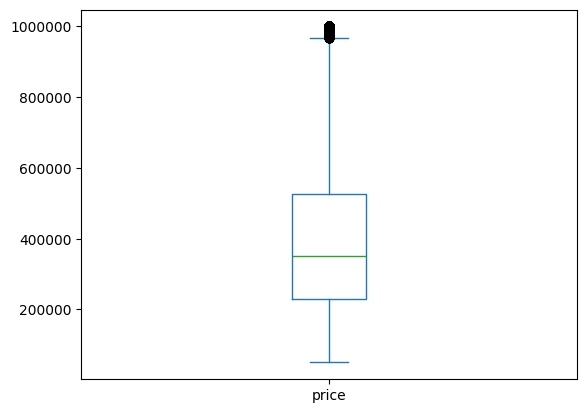

In [10]:
#I do not like seing visuals with scientific notation format.
pd.set_option('display.float_format', '{:.2f}'.format)
df['price'].describe()
df = df[(df['price'] >= 50000) & (df['price'] <= 1000000)]
df['price'].plot(kind='box')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [11]:
#lisf of count of houses with lowst price to highest price in the dataset
list_price = df['price'].value_counts().sort_index()

I filtered for houses priced below 1 million dollars because the 75th percentile of the price distribution is at $550,000. By keeping the price variable below 1 million dollars, I aim to improve the accuracy of the predictions by reducing the number of outliers in the price variable.

House Size variable

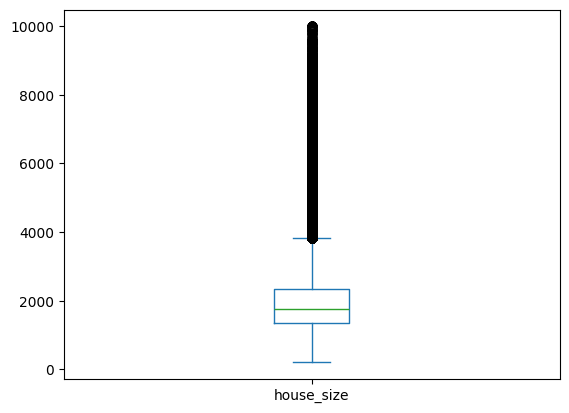

In [13]:
df['house_size'].describe()
list_size = df[df['house_size'] > 4000].shape[0]
list_size
df['house_size'].plot(kind='box')
plt.ticklabel_format(style='plain', axis='y')
plt.show()
df = df[(df['house_size'] >= 200) & (df['house_size'] <= 10000)]

There were outliers from houses that looked extremley big, such as a house with 1040400400 sqft. I decided to filter the data to have houses below 10000 sqft and above 200 sqft since i saw that 75% of the data has houses that are below 2238 sqft. Therefore, it will decrease the influence of outliers and at the same time allow for a reasonable range of larger homes. 

Bed variable

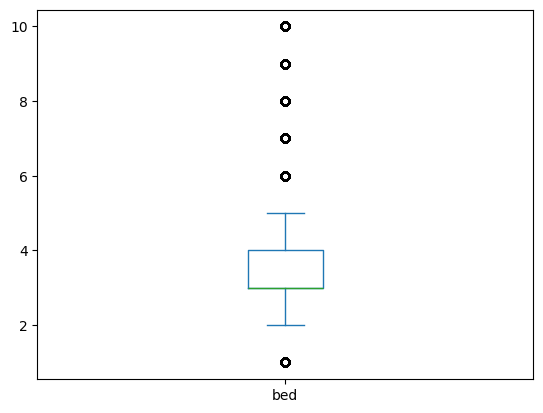

In [15]:
df['bed'].describe()
df['bed'].plot(kind='box')
df['bed'].value_counts().sort_values(ascending=False)
df = df[df['bed'] <= 10]

I filtered the data to have houses with less than or equal to 10 beds. There was an outier of a house with 444 beds which is most likely a mistake. The 75% percentile of the bed distribution is 4, so this filter ensures the data reflects realistic values while retaining some houses with more beds.

In [16]:
df.shape

(1282177, 10)

Bathroom variable

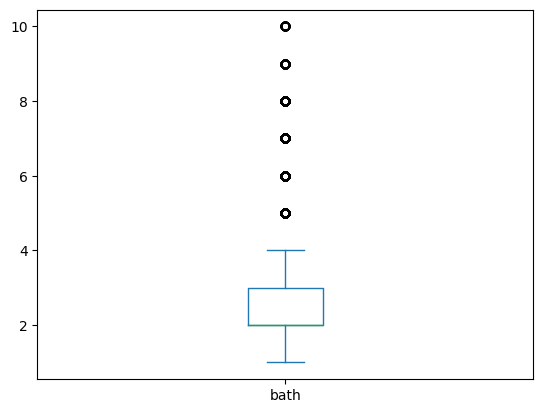

In [18]:
df['bath'].describe()
df['bath'].plot(kind='box')
df['bath'].value_counts().sort_values(ascending=False)
df = df[df['bath'] <= 10]

I filtered the data to have houses that have 10 bathrooms or less. There were outliers of houses with 175 bathrooms, which is unrealistic. Furthermore, 75% of the data has houses with 3 bathrooms or less, which means that I will not be losing much data while keeping some larger houses with more bathrooms.

State Variable

In [20]:
df['state'].value_counts().sort_values(ascending=True)  

state
Guam                       104
Virgin Islands             115
Alaska                     781
Vermont                   1137
Puerto Rico               1587
Wyoming                   1591
New Hampshire             1603
District of Columbia      1689
South Dakota              1913
Maine                     2065
North Dakota              2312
Hawaii                    2671
Nebraska                  4223
Montana                   4279
Delaware                  6107
Rhode Island              6183
West Virginia             6773
Mississippi               7214
Utah                      7978
Connecticut               8088
Nevada                    8926
Idaho                    10299
Kansas                   10747
Arkansas                 10866
Indiana                  11124
New Mexico               11621
Louisiana                13750
Alabama                  13763
Kentucky                 16011
Iowa                     16031
Colorado                 16296
Wisconsin                17887
Te

I will leave the State variable now to check how it would affect the model. Might have to filter for states that do not have many houses. 

City Variable

In [ ]:
df['city'].value_counts().sort_values(ascending=False)  

The city with the most listings is in Houston. Will see in the model if i need to adjust this. 

Zip Code

In [ ]:
df['zip_code'].value_counts().sort_values(ascending=False)  

Will see later if i need to adjust for the model.

Previously sold date

In [ ]:
df['prev_sold_date'].describe()

The oldest data point is a house in October 2021. The oldest listing in the data is in May of 2022.

Correlation between price and other variables

In [21]:
numeric_df = df[['price', 'bed', 'bath', 'house_size']]
correlation = numeric_df.corr()['price']
print(correlation)

price        1.00
bed          0.29
bath         0.48
house_size   0.47
Name: price, dtype: float64


The variables bed, bath, and house size have a positive correlation with price. The numeric variables I will use are bath, bed, and house size since they will be the most important for predicting home prices.

Save and import the Data

In [ ]:
df.to_csv('Real_Estate_Model.csv', index=False)